# Spoofing Impact Analysis

In [1]:
import sys
import datetime  
import numpy as np
import pandas as pd
import scipy.stats as stats
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import calendar, time


from abides_core import abides
from abides_core.utils import parse_logs_df, ns_date, str_to_ns, fmt_ts

In [2]:
sys.path.append("../")

## Reference Market Simulation Configurations

### Configurations

In [3]:
from configs import rmsc

save_log = False
dir = 'log/Spoofing/'
vanilla_dir = 'log/noSpoofing/'

seed = 2342

date = "20220101"
end_time = "16:00:00"

num_noise_agents = 100
num_value_agents = 150
num_momentum_agents = 10
num_spoofing_agents = 5
num_imbalance_agents = 3
num_market_makers = 3

without_spoofing_config = rmsc.build_config(
    seed=seed,
    end_time=end_time,
    num_noise_agents=num_noise_agents,
    num_value_agents=num_value_agents,
    num_momentum_agents=num_momentum_agents,
    num_spoofing_agents=0,
    num_imbalance_agents=num_imbalance_agents,
    num_market_makers=num_market_makers,
)

with_spoofing_config = rmsc.build_config(
    seed=seed,
    end_time=end_time,
    num_noise_agents=num_noise_agents,
    num_value_agents=num_value_agents,
    num_momentum_agents=num_momentum_agents,
    num_spoofing_agents=num_spoofing_agents,
    num_imbalance_agents=num_imbalance_agents,
    num_market_makers=num_market_makers,
)

## Experiments

In [4]:
from abides_core import Kernel

In [5]:
if save_log == True:
    end_state = abides.run(with_spoofing_config)

In [6]:
if save_log == True:
    vanilla_end_state = abides.run(without_spoofing_config)

## Midprice Comparision

In [7]:
def get_mid_price(state):
    
    L1 = state["agents"][0].order_books["ABM"].get_L1_snapshots()
    
    best_bids = pd.DataFrame(L1["best_bids"],columns=["time","price","qty"])
    best_asks = pd.DataFrame(L1["best_asks"],columns=["time","price","qty"])
    
    return pd.DataFrame({
        "time": best_bids.time.apply( lambda x: x - ns_date(x)),
        "midprice": (best_bids.price + best_asks.price)/2
    })

In [8]:
if save_log == True:
    midprice = get_mid_price(end_state).fillna(method='ffill')
    midprice.to_pickle(f'{dir}midprice.bz2')
else:
    midprice = pd.read_pickle(f'{dir}midprice.bz2')
                              
if save_log == True:
    vanilla_midprice = get_mid_price(vanilla_end_state).fillna(method='ffill')
    vanilla_midprice.to_pickle(f'{vanilla_dir}vanilla_midprice.bz2')    
else:
    vanilla_midprice = pd.read_pickle(f'{vanilla_dir}vanilla_midprice.bz2')

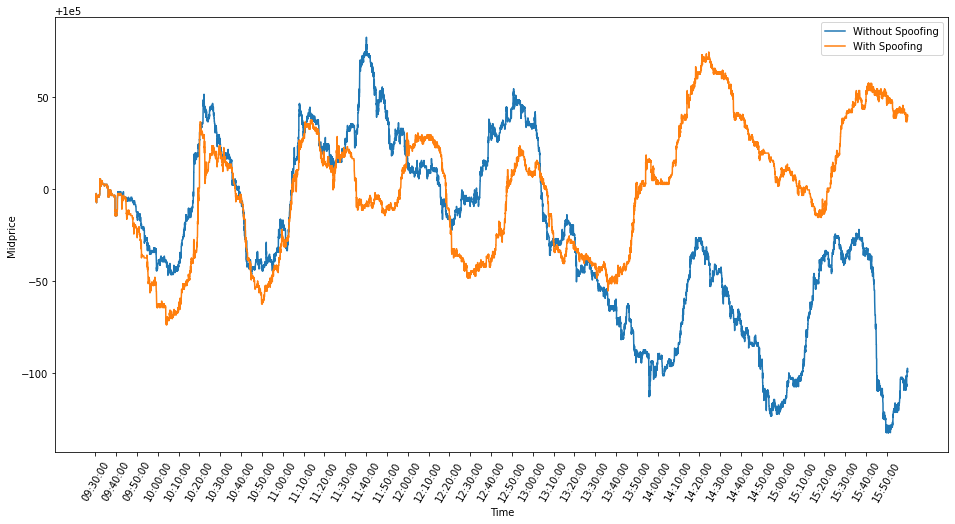

In [9]:
plt.figure(figsize=(16,8))
plt.plot(vanilla_midprice.time, vanilla_midprice.midprice, label = "Without Spoofing")
plt.plot(midprice.time, midprice.midprice, label = "With Spoofing")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Midprice")

time_mesh = np.arange(
    str_to_ns("09:30:00"),
    str_to_ns(end_time) + 6e-11,
    1e9*60*10
)

_ = plt.xticks(time_mesh, [fmt_ts(time).split(" ")[1] for time in time_mesh], rotation = 60)

## More Logs

In [10]:
if save_log == True:
    logs_df = parse_logs_df(end_state)
    logs_df.to_pickle(f'{dir}logs_df.bz2')
else:
    logs_df = pd.read_pickle(f'{dir}logs_df.bz2')
if save_log == True:
    vanilla_logs_df = parse_logs_df(vanilla_end_state)
    vanilla_logs_df.to_pickle(f'{vanilla_dir}vanilla_logs_df.bz2')
else:
    vanilla_logs_df = pd.read_pickle(f'{vanilla_dir}vanilla_logs_df.bz2')

In [11]:
spoofing_orders_submitted = logs_df[(logs_df.agent_type == 'SpoofingAgent') & (logs_df.EventType == 'ORDER_SUBMITTED') & (logs_df.tag == 'spoofing')]
spoofing_orders_executed = logs_df[(logs_df.agent_type == 'SpoofingAgent') & (logs_df.EventType == 'ORDER_EXECUTED') & (logs_df.tag == 'spoofing')]
position_orders_submitted = logs_df[(logs_df.agent_type == 'SpoofingAgent') & (logs_df.EventType == 'ORDER_SUBMITTED') & (logs_df.tag == 'position')]
position_orders_executed = logs_df[(logs_df.agent_type == 'SpoofingAgent') & (logs_df.EventType == 'ORDER_EXECUTED') & (logs_df.tag == 'position')]

In [12]:
len(logs_df[(logs_df.agent_type == 'SpoofingAgent') & (logs_df.EventType == 'ORDER_SUBMITTED') & (logs_df.tag == 'spoofing')])

4574

In [13]:
logs_df[(logs_df.agent_type == 'SpoofingAgent') & (logs_df.EventType == 'ORDER_SUBMITTED') & (logs_df.tag == 'spoofing')].side.unique()

array([<Side.BID: 'BID'>], dtype=object)

In [14]:
len(logs_df[(logs_df.agent_type == 'SpoofingAgent') & (logs_df.EventType == 'ORDER_SUBMITTED') & (logs_df.tag == 'position')])

30

In [15]:
len(logs_df[(logs_df.agent_type == 'SpoofingAgent') & (logs_df.EventType == 'ORDER_EXECUTED') & (logs_df.tag == 'spoofing')])

41

In [16]:
len(logs_df[(logs_df.agent_type == 'SpoofingAgent') & (logs_df.EventType == 'ORDER_CANCELLED') & (logs_df.tag == 'spoofing')])

4567

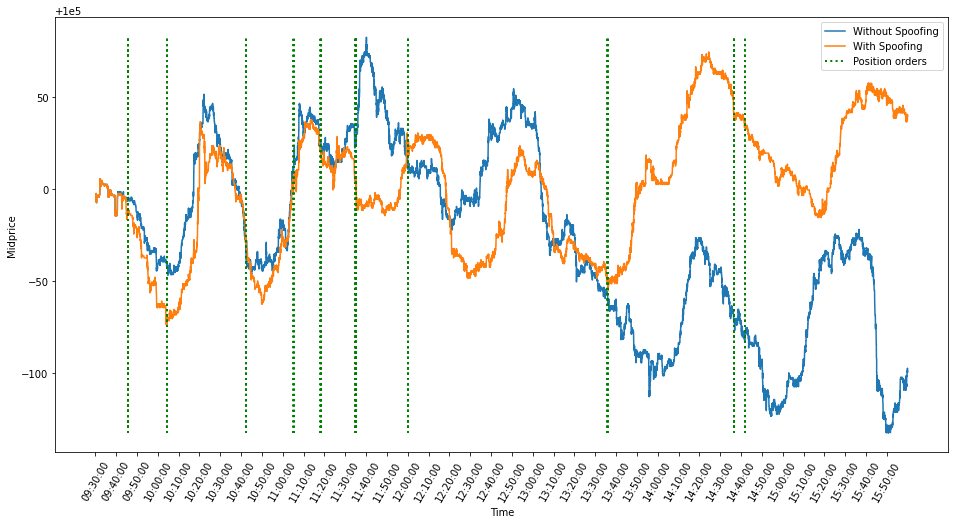

In [17]:
plt.figure(figsize=(16,8))
plt.plot(vanilla_midprice[~vanilla_midprice.midprice.isna()].time, vanilla_midprice[~vanilla_midprice.midprice.isna()].midprice, label = "Without Spoofing")
plt.plot(midprice[~midprice.midprice.isna()].time, midprice[~midprice.midprice.isna()].midprice, label = "With Spoofing")
plt.xlabel("Time")
plt.ylabel("Midprice")
plt.vlines(x=position_orders_executed.EventTime.apply(lambda x: x - ns_date(x)), 
           ymin = min(min(midprice[~midprice.midprice.isna()].midprice), min(vanilla_midprice[~vanilla_midprice.midprice.isna()].midprice)),
           ymax = max(max(midprice[~midprice.midprice.isna()].midprice), max(vanilla_midprice[~vanilla_midprice.midprice.isna()].midprice)), 
           color='green', 
           linestyle='dotted', 
           linewidth=2,
           label='Position orders')

# plt.vlines(x=spoofing_orders_submitted.EventTime.apply(lambda x: x - ns_date(x)), 
#            ymin = min(min(midprice[~midprice.midprice.isna()].midprice), min(vanilla_midprice[~vanilla_midprice.midprice.isna()].midprice)),
#            ymax = max(max(midprice[~midprice.midprice.isna()].midprice), max(vanilla_midprice[~vanilla_midprice.midprice.isna()].midprice)), 
#            color='yellow', 
#            linestyle='dotted', 
#            linewidth=0.5,
#            label='Spoofing orders')
plt.legend()

time_mesh = np.arange(
    str_to_ns("09:30:00"),
    str_to_ns(end_time) 
    + 6e-11,1e9*60*10
)

_ = plt.xticks(time_mesh, [fmt_ts(time).split(" ")[1] for time in time_mesh], rotation = 60)

In [18]:
max(vanilla_midprice[~vanilla_midprice.midprice.isna()].midprice)

100082.5

In [19]:
def get_ohlcv(logs_df):

   
            
    # grab trade info from the agent
    last_trade_df = logs_df[logs_df['EventType'] == 'LAST_TRADE']
    last_trade_df['PRICE'] = [y for x,y in last_trade_df['ScalarEventValue'].str.split(',')]
    last_trade_df['SIZE'] = [x for x,y in last_trade_df['ScalarEventValue'].str.split(',')]
    last_trade_df['PRICE'] = last_trade_df['PRICE'].str.replace('$','').astype('float64')
    last_trade_df['SIZE'] = last_trade_df['SIZE'].astype('float64')

    # epoch to real time
#     last_trade_df['EventDate'] = ''
#     for i in range(len(last_trade_df.EventTime)):
#         if len(str(last_trade_df.EventTime.iloc[i])) == 19:
#             last_trade_df['EventDate'].iloc[i] = datetime.datetime.fromtimestamp(last_trade_df.EventTime.iloc[i] / 1000000000 + 3600*8 ).strftime('%Y-%m-%d %H:%M:%S.%f')
#         else:
#             last_trade_df['EventDate'].iloc[i] = last_trade_df.EventTime.iloc[i]
            
#     last_trade_df['EventDate'] = pd.to_datetime(last_trade_df['EventDate'])
    last_trade_df['EventDate'] = last_trade_df.EventTime.apply( lambda x: x - ns_date(x))
    last_trade_df['EventDate'] = pd.to_datetime(last_trade_df['EventDate'])
    
    # ignore exchange agent
    last_trade_df = last_trade_df[last_trade_df.EventTime!=0].set_index('EventDate')
            
    # populate trade info into order stream
    sim_order_stream = pd.DataFrame({
                                "Price": last_trade_df.PRICE,
                                "Size": last_trade_df.SIZE,
                                "Time": last_trade_df.index
    })

    

    # minutely resampling and renaming columns.
    last_trade_df2 = last_trade_df[["PRICE","SIZE"]].resample("1T")
    last_trade_df_open = last_trade_df2["PRICE"].first().ffill()
    last_trade_df_close = last_trade_df2["PRICE"].last().ffill()
    last_trade_df_high = last_trade_df2["PRICE"].max().ffill()
    last_trade_df_low = last_trade_df2["PRICE"].min().ffill()
    last_trade_df_vol = last_trade_df2["SIZE"].sum()
    ohlcv = pd.DataFrame({
        "open": last_trade_df_open,
        "high": last_trade_df_high,
        "low": last_trade_df_low,
        "close": last_trade_df_close,
        "volume": last_trade_df_vol
    })

    sim_orders = ohlcv[["open", "volume"]]
    return ohlcv, sim_order_stream

In [20]:
if save_log == True:
    ohlcv, order_stream = get_ohlcv(logs_df)
    ohlcv.to_pickle(f'{dir}ohlcv.bz2')
    order_stream.to_pickle(f'{dir}order_stream.bz2')
else:
    ohlcv = pd.read_pickle(f'{dir}ohlcv.bz2')
    order_stream = pd.read_pickle(f'{dir}order_stream.bz2')
    
if save_log == True:   
    vanilla_ohlcv, vanilla_order_stream = get_ohlcv(vanilla_logs_df)
    vanilla_ohlcv.to_pickle(f'{vanilla_dir}vanilla_ohlcv.bz2')
    vanilla_order_stream.to_pickle(f'{vanilla_dir}vanilla_order_stream.bz2')
else:
    vanilla_ohlcv = pd.read_pickle(f'{vanilla_dir}vanilla_ohlcv.bz2')
    vanilla_order_stream = pd.read_pickle(f'{vanilla_dir}vanilla_order_stream.bz2')


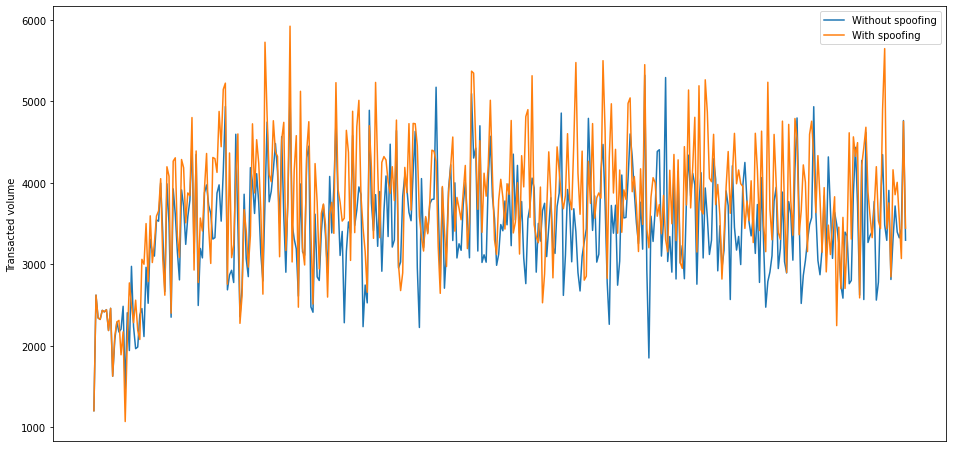

Total transacted volume = 1471098.0
Total transacted volume = 1344216.0


DescribeResult(nobs=390, minmax=(1072.0, 5923.0), mean=3772.0461538461536, variance=606372.573699822, skewness=-0.17905122958851594, kurtosis=0.20561493149968557)

DescribeResult(nobs=390, minmax=(1205.0, 5321.0), mean=3446.7076923076925, variance=452197.8423571287, skewness=-0.024391478620256018, kurtosis=0.1845771155981515)

In [21]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 8)
locs = np.arange(0,len(ohlcv.volume), step=10)
_= plt.xticks(time_mesh, [fmt_ts(time).split(" ")[1] for time in time_mesh], rotation = 60)
plt.ylabel('Transacted volume')
ax.plot(vanilla_ohlcv.index.astype(str), vanilla_ohlcv.volume, label = 'Without spoofing')
ax.plot(ohlcv.index.astype(str), ohlcv.volume, label = 'With spoofing')
ax.legend()
plt.show()
print('Total transacted volume =', ohlcv.volume.sum())
print('Total transacted volume =', vanilla_ohlcv.volume.sum())
display(stats.describe(ohlcv.volume))
display(stats.describe(vanilla_ohlcv.volume))

Text(0, 0.5, 'Volume transacted')

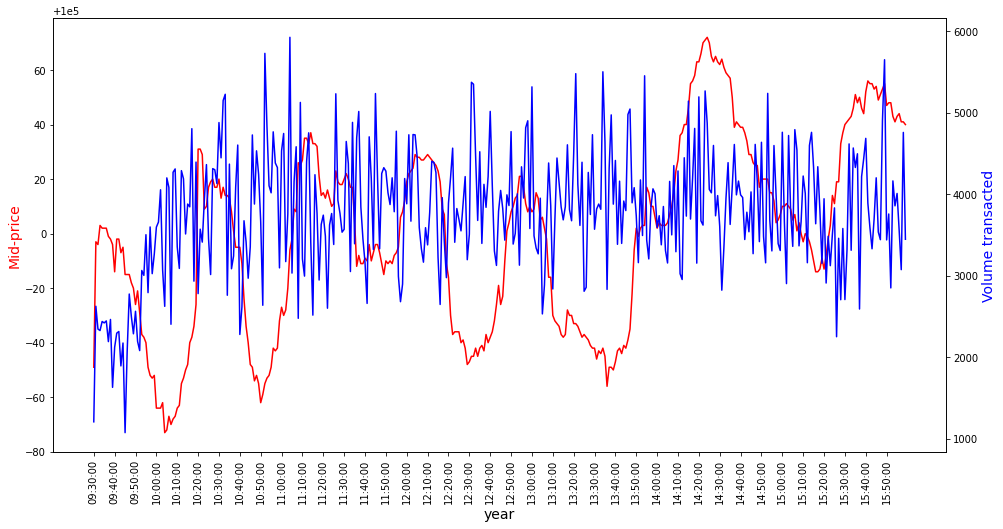

In [22]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
fig.set_size_inches(16, 8)
locs = np.arange(0,len(ohlcv.volume), step=10)
plt.xticks( locs, ohlcv.index.astype(str).str[-8:][locs], rotation="vertical" )
# make a plot
ax.plot(ohlcv.index.astype(str), ohlcv.open, color="red")
# set x-axis label
ax.set_xlabel("year",fontsize=14)
# set y-axis label
ax.set_ylabel("Mid-price",color="red",fontsize=14)
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(ohlcv.index.astype(str), ohlcv.volume,color="blue")
ax2.set_ylabel("Volume transacted",color="blue",fontsize=14)

# plt.show()

# plt.figure(figsize=(16,8))
# plt.plot(midprice.time, midprice.midprice, label = "With Spoofing")


# plt.legend()
# plt.xlabel("Time")
# plt.ylabel("Midprice")


# time_mesh = np.arange(
#     str_to_ns("09:30:00"),
#     str_to_ns(end_time) + 6e-11,
#     1e9*60*10
# )

# _ = plt.xticks(time_mesh, [fmt_ts(time).split(" ")[1] for time in time_mesh], rotation = 60)

In [23]:
rng = 10
# volume_bins = pd.DataFrame()
# volume_bins['time'] = ''
# volume_bins['volume'] = ''
sum_vol = []
time = []
for i in locs:
    x=0
    time.append(ohlcv.index[i])
    sum_vol.append(ohlcv.volume.iloc[i:i+10].sum())
    x+=1
sum_vol

[22072.0,
 21483.0,
 29068.0,
 36248.0,
 38267.0,
 37257.0,
 41822.0,
 35668.0,
 41533.0,
 41488.0,
 35837.0,
 37033.0,
 40898.0,
 39356.0,
 37676.0,
 39852.0,
 36419.0,
 38419.0,
 42457.0,
 38479.0,
 40373.0,
 36669.0,
 38561.0,
 40493.0,
 41199.0,
 41047.0,
 38537.0,
 36305.0,
 39415.0,
 42998.0,
 38574.0,
 38180.0,
 38780.0,
 39513.0,
 39986.0,
 32776.0,
 38563.0,
 40905.0,
 36892.0]

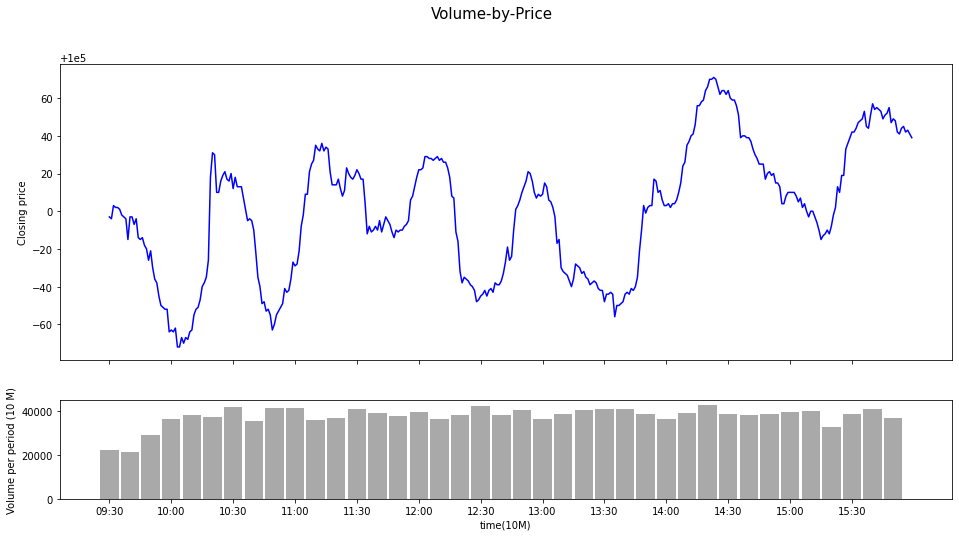

In [24]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})
fig.set_size_inches(16, 8)
# plt.xticks( locs, ohlcv.index.astype(str).str[-8:][locs], rotation="vertical" )
fig.suptitle('Volume-by-Price', fontsize = 15)
ax1.plot(ohlcv.index, ohlcv.close, color="blue")
# ax1.vlines(x=position_orders_executed.EventTime.apply(lambda x: x - ns_date(x)), 
#            ymin = min(midprice[~midprice.midprice.isna()].midprice),
#            ymax = max(midprice[~midprice.midprice.isna()].midprice),
#            color='green', 
#            linestyle='dotted', 
#            linewidth=2,
#            label='Position orders')
 

plt.setp(ax1, ylabel='Closing price')
ax2.set_xlabel('time(10M)')
ax2.bar(time, sum_vol, width = 0.0062, color="darkgrey")
plt.setp(ax2, ylabel='Volume per period (10 M)')
xfmt = mdates.DateFormatter('%H:%M')
ax2.set_xticks(time[::3])
ax2.xaxis.set_major_formatter(xfmt)


In [25]:
summary = logs_df[logs_df.EventType.isin(['ENDING_CASH','FINAL_CASH_POSITION','STARTING_CASH','ENDING_CASH'])].groupby(['agent_type', 'EventType'])['ScalarEventValue'].agg('sum').reset_index(1)
summary_id = logs_df[logs_df.EventType.isin(['ENDING_CASH','FINAL_CASH_POSITION','STARTING_CASH','ENDING_CASH'])]
vanilla_summary = vanilla_logs_df[vanilla_logs_df.EventType.isin(['ENDING_CASH','FINAL_CASH_POSITION','STARTING_CASH','ENDING_CASH'])].groupby(['agent_type', 'EventType'])['ScalarEventValue'].agg('sum').reset_index(1)
vanilla_summary_id = vanilla_logs_df[vanilla_logs_df.EventType.isin(['ENDING_CASH','FINAL_CASH_POSITION','STARTING_CASH','ENDING_CASH'])]


In [26]:
def surplus(logs_df, summary, summary_id, del_spoofer=False):
    surplus = {}
    agents = logs_df[logs_df.EventType.isin(['ENDING_CASH','FINAL_CASH_POSITION','STARTING_CASH','ENDING_CASH'])].agent_type.unique()
    
    if del_spoofer == True:
        np.delete(agents, np.where(agents == 'SpoofingAgent'))
        
    for i in agents:
        surplus[i] = \
        summary[(summary.index==i) & (summary.EventType=='ENDING_CASH')]['ScalarEventValue'][0]\
            - summary[(summary.index==i) & (summary.EventType=='STARTING_CASH')]['ScalarEventValue'][0]

    def sort_dict(dic):
        sorted_values = sorted(dic.values(), reverse=True) # Sort the values
        sorted_dict = {}

        for i in sorted_values:
            for k in dic.keys():
                if dic[k] == i:
                    sorted_dict[k] = dic[k]
        return sorted_dict
        
    total_surplus = sort_dict(surplus)

    print('--------------------------------------------------------')
    print(f'The market surplus is: {np.sum(np.array(list(total_surplus.values())))}')
    print('--------------------------------------------------------')

    print(f'The total ending value per agent strategy is:\n')
    for key in total_surplus:
        print(f'{key}, {total_surplus[key]}')
    
    number_agents = summary_id.groupby('agent_type')['agent_id'].nunique()
    
    average_surplus_per_agent_strategy = total_surplus.copy()

    for i in average_surplus_per_agent_strategy:
        average_surplus_per_agent_strategy[i]=total_surplus[i]/number_agents[i]

    average_surplus_per_agent_strategy = sort_dict(average_surplus_per_agent_strategy)

    plt.figure(figsize = (16,8))
    sns.set_theme(style="whitegrid")
    sns.barplot(x = list(total_surplus.keys()), y = list(total_surplus.values()))
    plt.title('Payoff per agent strategy')
    plt.show();
    
    print('--------------------------------------------------------')
    print(f'The mean ending value per agent strategy is:\n')
    for key in average_surplus_per_agent_strategy:
        print(f'{key}, {average_surplus_per_agent_strategy[key]}')

    plt.figure(figsize = (16,8))
    sns.set_theme(style="whitegrid")
    sns.barplot(x = list(average_surplus_per_agent_strategy.keys()), y = list(average_surplus_per_agent_strategy.values()), label = 'Withour spoofing')
    plt.title('Average payoff per agent strategy')
    plt.show();
    print('--------------------------------------------------------')

    number_agents = number_agents.sort_values(ascending=False)
    
    print('Number of agents:')
    display(number_agents)
    x=0
    labels = []
    
    for i in number_agents.index:
        labels.append(f'{i}, {number_agents[i]}, {int(np.round(number_agents[i]/number_agents.sum(),2)*100)}%')
        x+=1
        
    plt.figure(figsize = (15,8))
    plt.pie(number_agents)
    plt.legend(labels)
    plt.show();
    return pd.DataFrame.from_dict(average_surplus_per_agent_strategy, orient='index')

--------------------------------------------------------
The market surplus is: 0
--------------------------------------------------------
The total ending value per agent strategy is:

ValueAgent, 12587408
ImbalanceAgent, 8567015
SpoofingAgent, 19652
NoiseAgent, -18978
AdaptivePOVMarketMakerAgent, -2398283
MomentumAgent, -18756814


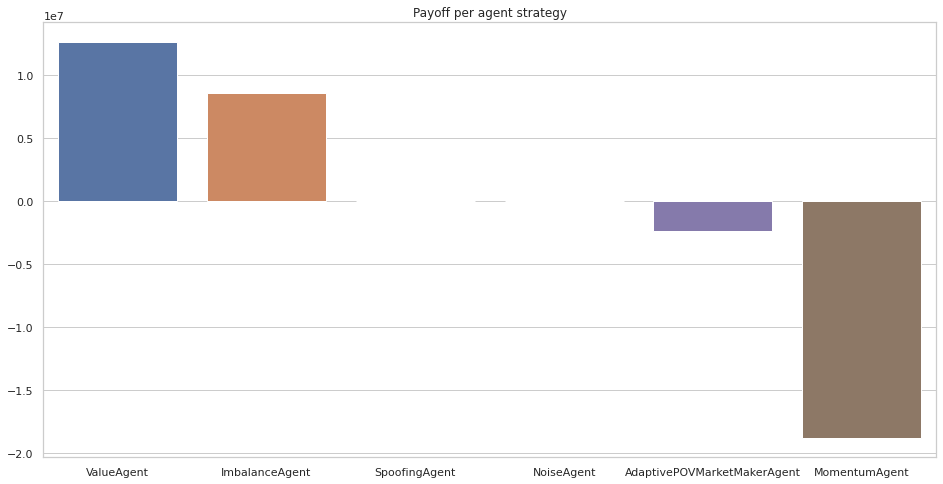

--------------------------------------------------------
The mean ending value per agent strategy is:

ImbalanceAgent, 2855671.6666666665
ValueAgent, 83916.05333333333
SpoofingAgent, 3930.4
NoiseAgent, -189.78
AdaptivePOVMarketMakerAgent, -799427.6666666666
MomentumAgent, -1875681.4


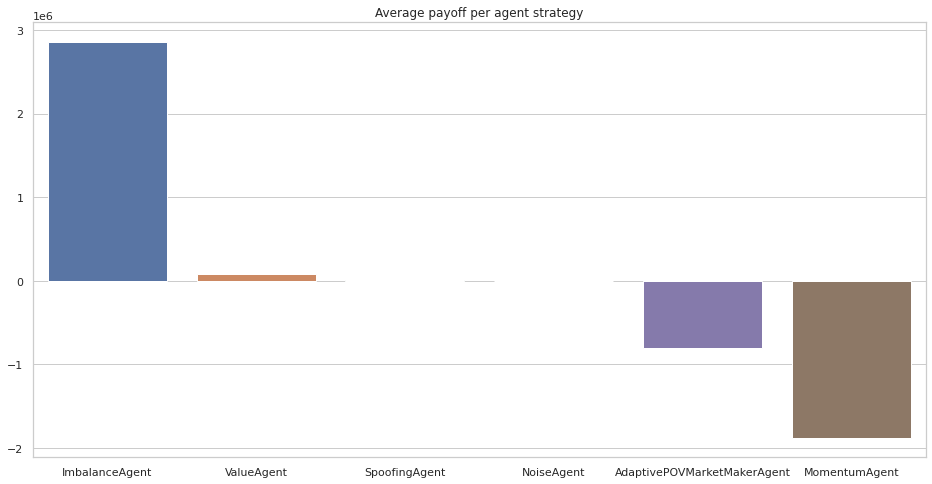

--------------------------------------------------------
Number of agents:


agent_type
ValueAgent                     150
NoiseAgent                     100
MomentumAgent                   10
SpoofingAgent                    5
AdaptivePOVMarketMakerAgent      3
ImbalanceAgent                   3
Name: agent_id, dtype: int64

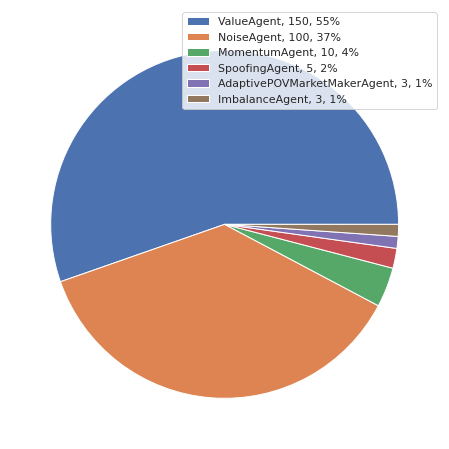

In [27]:
avg_surplus = surplus(logs_df, summary, summary_id)

--------------------------------------------------------
The market surplus is: 0
--------------------------------------------------------
The total ending value per agent strategy is:

ValueAgent, 8302160
AdaptivePOVMarketMakerAgent, 525931
ImbalanceAgent, 503118
NoiseAgent, 179287
MomentumAgent, -9510496


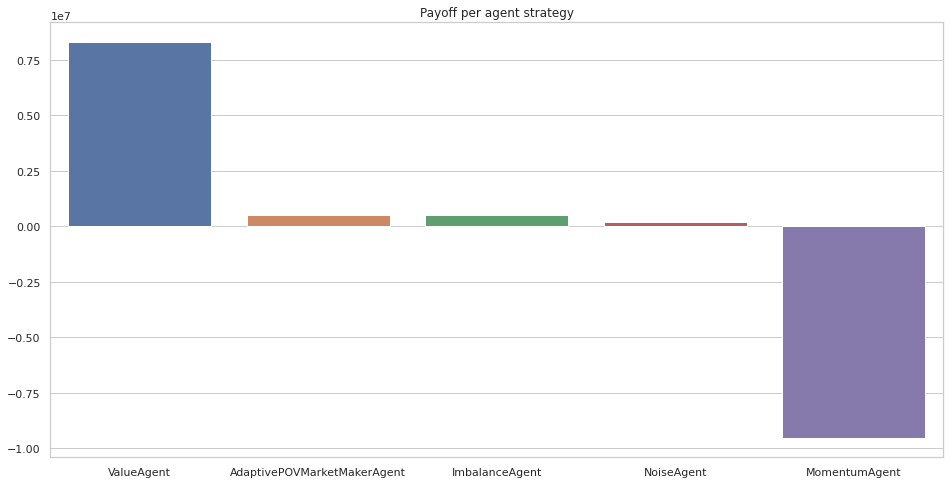

--------------------------------------------------------
The mean ending value per agent strategy is:

AdaptivePOVMarketMakerAgent, 175310.33333333334
ImbalanceAgent, 167706.0
ValueAgent, 55347.73333333333
NoiseAgent, 1792.87
MomentumAgent, -951049.6


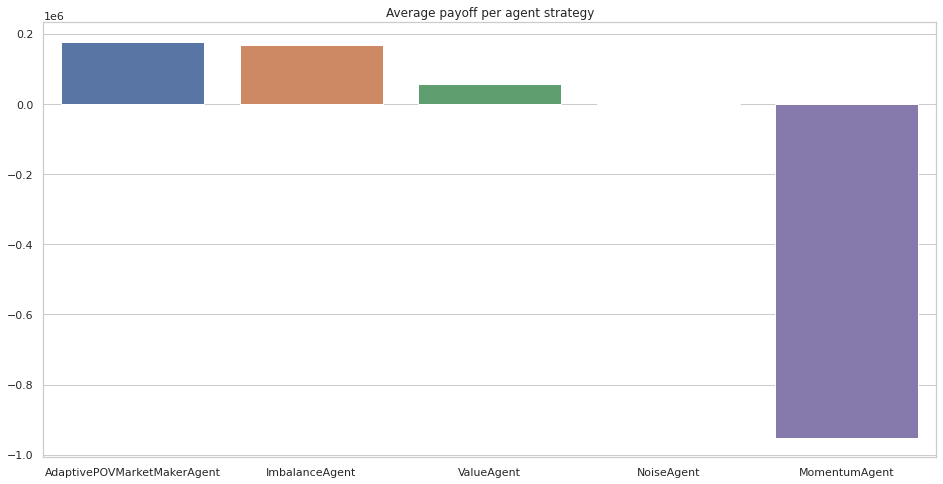

--------------------------------------------------------
Number of agents:


agent_type
ValueAgent                     150
NoiseAgent                     100
MomentumAgent                   10
AdaptivePOVMarketMakerAgent      3
ImbalanceAgent                   3
Name: agent_id, dtype: int64

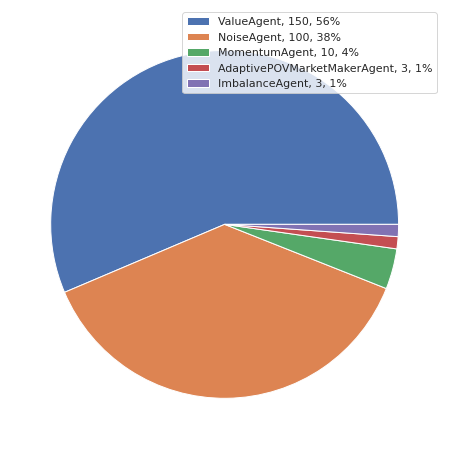

In [28]:
vanilla_avg_surplus = surplus(vanilla_logs_df, vanilla_summary, vanilla_summary_id)

In [29]:
surplus_comparison = pd.concat([avg_surplus, vanilla_avg_surplus], axis=0).reset_index().rename(columns={'index':'strategy',0:'surplus'})
surplus_comparison = surplus_comparison[surplus_comparison.strategy != 'SpoofingAgent']
surplus_comparison['scenario'] = ''
for i in range(len(surplus_comparison)):
    if i<len(surplus_comparison)/2:
        surplus_comparison['scenario'].iloc[i] = 'With spoofing'
    else:
        surplus_comparison['scenario'].iloc[i] = 'Without spoofing'

/tmp/ipykernel_1377/1170609260.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  surplus_comparison['scenario'].iloc[i] = 'With spoofing'
/tmp/ipykernel_1377/1170609260.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  surplus_comparison['scenario'].iloc[i] = 'Without spoofing'


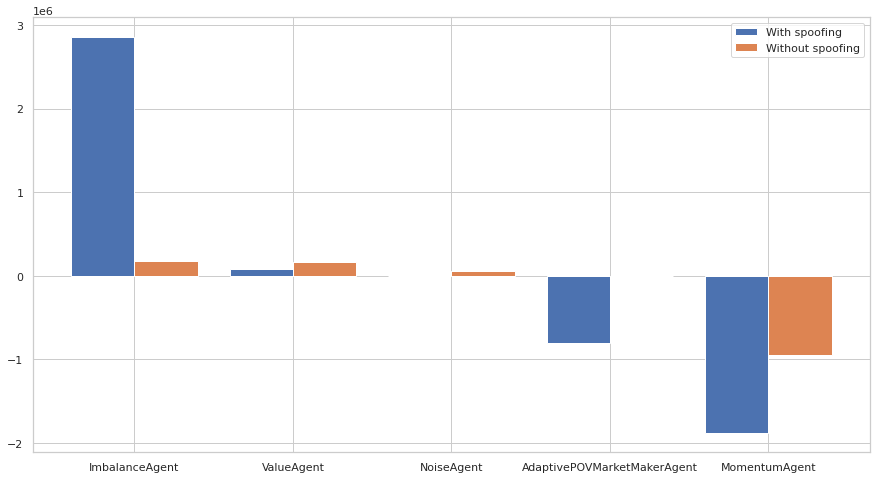

In [30]:
plt.figure(figsize = (15,8))
X_axis = np.arange(len(surplus_comparison[surplus_comparison.scenario=='With spoofing']))
X_axis
plt.bar(X_axis-0.2, surplus_comparison[surplus_comparison.scenario=='With spoofing'].surplus, 0.4, label = 'With spoofing')
plt.bar(X_axis+0.2, surplus_comparison[surplus_comparison.scenario=='Without spoofing'].surplus, 0.4, label = 'Without spoofing')
plt.xticks(X_axis, surplus_comparison[surplus_comparison.scenario=='With spoofing'].strategy)
plt.legend()
plt.show();
# print(f'With spoofing, the average surplus increases/decreases:')
# for i in range(len(surplus_comparison/2)):
#     print(f'{surplus_comparison.strategy}, {(surplus_comparison[surplus_comparison.scenario=='With spoofing'].surplus)})

In [31]:
if save_log == True:
    order_book = end_state["agents"][0].order_books["ABM"]
    L1 = order_book.get_L1_snapshots()
    L2 = order_book.get_L2_snapshots(nlevels=10)
    test = pd.DataFrame({k:list(v) for k,v in L1.items()})
    best_bids=pd.DataFrame(test['best_bids'].to_list()).rename(columns={0:'time',1:'price',2:'quantity'})
    best_asks=pd.DataFrame(test['best_asks'].to_list()).rename(columns={0:'time',1:'price',2:'quantity'})
    best_bids.time = best_bids.time.apply( lambda x: x - ns_date(x) )
    best_asks.time = best_asks.time.apply( lambda x: x - ns_date(x) )
    
    best_asks.to_pickle(f'{dir}best_asks.bz2')
    best_bids.to_pickle(f'{dir}best_bids.bz2')
    
    test2 = pd.DataFrame({k:list(v) for k,v in L2.items()})
    bids = pd.DataFrame.from_records(test2.bids.to_list())
    bids['time'] = ''
    bids.time = test2.times
    bids.time = bids.time.apply( lambda x: x - ns_date(x) )
    asks = pd.DataFrame.from_records(test2.asks.to_list())
    asks['time'] = ''
    asks.time = test2.times
    asks.time = asks.time.apply( lambda x: x - ns_date(x) )

    asks.to_pickle(f'{dir}asks.bz2')
    bids.to_pickle(f'{dir}bids.bz2')
    best_bids = pd.DataFrame(L1["best_bids"],columns=["time","price","quantity"])
    best_asks = pd.DataFrame(L1["best_asks"],columns=["time","price","quantity"])

else:
    best_asks = pd.read_pickle(f'{dir}best_asks.bz2')
    best_bids = pd.read_pickle(f'{dir}best_bids.bz2')
    asks = pd.read_pickle(f'{dir}asks.bz2')
    bids = pd.read_pickle(f'{dir}bids.bz2')

if save_log == True:
    vanilla_order_book = vanilla_end_state["agents"][0].order_books["ABM"]
    vanilla_L1 = vanilla_order_book.get_L1_snapshots()
    vanilla_L2 = vanilla_order_book.get_L2_snapshots(nlevels=10)
    vanilla_test = pd.DataFrame({k:list(v) for k,v in vanilla_L1.items()})
    vanilla_best_bids=pd.DataFrame(vanilla_test['best_bids'].to_list()).rename(columns={0:'time',1:'price',2:'quantity'})
    vanilla_best_asks=pd.DataFrame(vanilla_test['best_asks'].to_list()).rename(columns={0:'time',1:'price',2:'quantity'})
    vanilla_best_bids.time = vanilla_best_bids.time.apply( lambda x: x - ns_date(x) )
    vanilla_best_asks.time = vanilla_best_asks.time.apply( lambda x: x - ns_date(x) )

    vanilla_best_asks.to_pickle(f'{vanilla_dir}vanilla_best_asks.bz2')
    vanilla_best_bids.to_pickle(f'{vanilla_dir}vanilla_best_bids.bz2')
    
    vanilla_test2 = pd.DataFrame({k:list(v) for k,v in vanilla_L2.items()})
    vanilla_bids = pd.DataFrame.from_records(vanilla_test2.bids.to_list())
    vanilla_bids['time'] = ''
    vanilla_bids.time = vanilla_test2.times
    vanilla_bids.time = vanilla_bids.time.apply( lambda x: x - ns_date(x) )
    vanilla_asks = pd.DataFrame.from_records(vanilla_test2.asks.to_list())
    vanilla_asks['time'] = ''
    vanilla_asks.time = vanilla_test2.times
    vanilla_asks.time = vanilla_asks.time.apply( lambda x: x - ns_date(x) )

    vanilla_asks.to_pickle(f'{vanilla_dir}vanilla_asks.bz2')
    vanilla_bids.to_pickle(f'{vanilla_dir}vanilla_bids.bz2')
    
    vanilla_best_bids = pd.DataFrame(vanilla_L1["best_bids"],columns=["time","price","quantity"])
    vanilla_best_asks = pd.DataFrame(vanilla_L1["best_asks"],columns=["time","price","quantity"])

else:
    vanilla_best_asks = pd.read_pickle(f'{vanilla_dir}vanilla_best_asks.bz2')
    vanilla_best_bids = pd.read_pickle(f'{vanilla_dir}vanilla_best_bids.bz2')
    vanilla_asks = pd.read_pickle(f'{vanilla_dir}vanilla_asks.bz2')
    vanilla_bids = pd.read_pickle(f'{vanilla_dir}vanilla_bids.bz2')

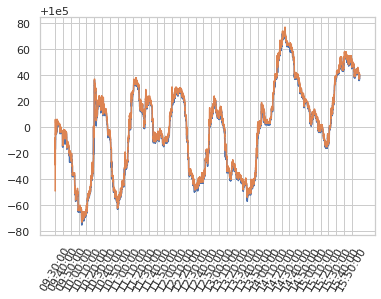

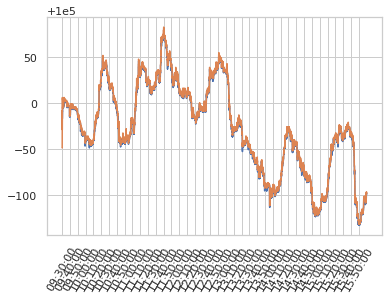

In [32]:
## All times are in ns from 1970, remove the date component to put them in ns from midnight
best_bids["time"] = best_bids["time"].apply( lambda x: x - ns_date(x) )
best_asks["time"] = best_asks["time"].apply( lambda x: x - ns_date(x) )

plt.plot(best_bids.time,best_bids.price)
plt.plot(best_asks.time,best_asks.price)
_ = plt.xticks(time_mesh, [fmt_ts(time).split(" ")[1] for time in time_mesh], rotation = 60)
plt.show();

## All times are in ns from 1970, remove the date component to put them in ns from midnight
vanilla_best_bids["time"] = vanilla_best_bids["time"].apply( lambda x: x - ns_date(x) )
vanilla_best_asks["time"] = vanilla_best_asks["time"].apply( lambda x: x - ns_date(x) )

plt.plot(vanilla_best_bids.time,vanilla_best_bids.price)
plt.plot(vanilla_best_asks.time,vanilla_best_asks.price)
_ = plt.xticks(time_mesh, [fmt_ts(time).split(" ")[1] for time in time_mesh], rotation = 60)
plt.show();

In [33]:
if save_log == True:
    ## plotting tenth best bid and tenth best ask
    fig, (ax1, ax2) = plt.subplots(2, sharex=True)
    fig.suptitle("Title centered above all subplots", fontsize=28)
    fig.set_figheight(15)
    fig.set_figwidth(15)
    _=plt.xticks(time_mesh, [ fmt_ts(time).split(" ")[1] for time in time_mesh], rotation=60 )

    plt.figure(1, figsize = (30,11))
    ax1.set_ylim([99_750, 100_250])
    ax2.set_ylim([99_750, 100_250])
    ax1.legend()
    ax2.legend()
    plt.figure(figsize = (15,8))
    times = [ t - ns_date(t) for t in L2["times"] ]
#     plt.ylim(99_500,100_500)
    ax1.scatter( times, L2["bids"][:,4,0], s=.5 , label = '5th best bid')
    ax1.scatter( times, L2["asks"][:,4,0], s=.5 , label = '5th best ask')
    times = [ t - ns_date(t) for t in vanilla_L2["times"] ]
    ax2.scatter( times, vanilla_L2["bids"][:,4,0], s=.5 , label = '5th best bid')
    ax2.scatter( times, vanilla_L2["asks"][:,4,0], s=.5 , label = '5th best ask')

#     plt.show();
    times = []
    bid_price = []
    bid_size = []

    for i in range(len(L2['bids'])):
        bid_price.append([item[0] for item in L2['bids'][i]])
        bid_size.append([item[1] for item in L2['bids'][i]])
        times.append(L2['times'][i])

    ask_price = []
    ask_size = []

    for i in range(len(L2['asks'])):
        ask_price.append([item[0] for item in L2['asks'][i]])
        ask_size.append([item[1] for item in L2['asks'][i]])

In [34]:
if save_log == True:
    ## plotting tenth best bid and tenth best ask
    plt.figure(figsize = (15,8))
    times = [ t - ns_date(t) for t in vanilla_L2["times"] ]
    plt.scatter( times, vanilla_L2["bids"][:,9,0], s=.5 )
    plt.scatter( times, vanilla_L2["asks"][:,9,0], s=.5 )
    plt.ylim(99_500,100_500)
    plt.ylabel('Price')

    _=plt.xticks(time_mesh, [ fmt_ts(time).split(" ")[1] for time in time_mesh], rotation=60 )
    plt.show();
    vanilla_bid_price = []
    vanilla_bid_size = []
    vanilla_times = []

    for i in range(len(vanilla_L2['bids'])):
        vanilla_bid_price.append([item[0] for item in vanilla_L2['bids'][i]])
        vanilla_bid_size.append([item[1] for item in vanilla_L2['bids'][i]])
        vanilla_times.append(vanilla_L2['times'][i])

    vanilla_ask_price = []
    vanilla_ask_size = []

    for i in range(len(vanilla_L2['asks'])):
        vanilla_ask_price.append([item[0] for item in vanilla_L2['asks'][i]])
        vanilla_ask_size.append([item[1] for item in vanilla_L2['asks'][i]])

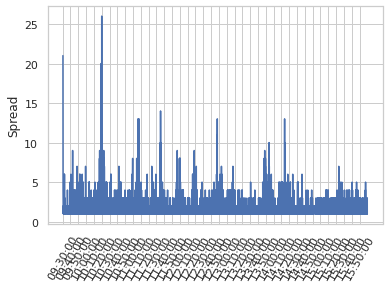

1.37978118904249


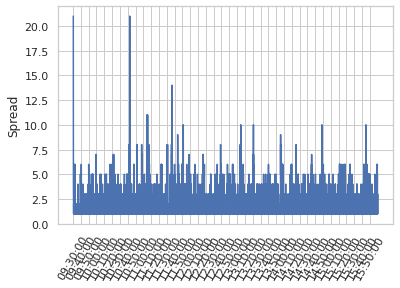

1.397394534215378


In [35]:
plt.plot(best_asks.time,best_asks.price-best_bids.price, label = 'With spoofing')
_ = plt.xticks(time_mesh, [fmt_ts(time).split(" ")[1] for time in time_mesh], rotation = 60)
plt.ylabel('Spread')
plt.show();
print(np.mean(best_asks.price-best_bids.price))

plt.plot(vanilla_best_asks.time,vanilla_best_asks.price-vanilla_best_bids.price, label = 'Without spoofing')
_ = plt.xticks(time_mesh, [fmt_ts(time).split(" ")[1] for time in time_mesh], rotation = 60)
plt.ylabel('Spread')
plt.show();
print(np.mean(vanilla_best_asks.price-vanilla_best_bids.price))

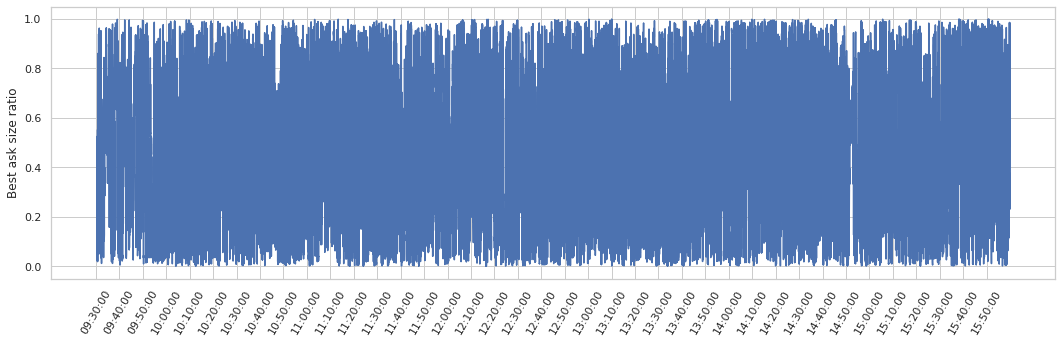

With spoofing
Mean best ask size ratio: 0.45383775168185514


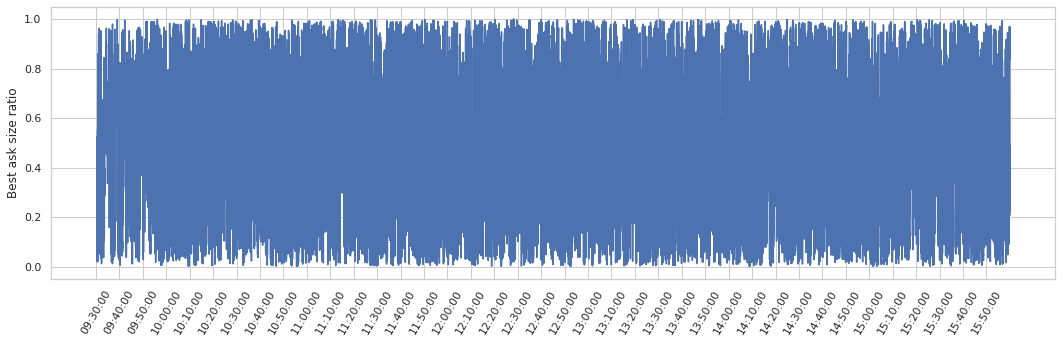

Without spoofing
Mean best ask size ratio: 0.4924579963481549


In [36]:
plt.figure(figsize=(18, 5))
plt.plot(best_asks.time,best_asks.quantity/(best_bids.quantity+best_asks.quantity), label = 'With spoofing')
_ = plt.xticks(time_mesh, [fmt_ts(time).split(" ")[1] for time in time_mesh], rotation = 60)
plt.ylabel('Best ask size ratio')
plt.show()
print('With spoofing')
print(f'Mean best ask size ratio: {np.mean(best_asks.quantity/(best_bids.quantity+best_asks.quantity))}')


plt.figure(figsize=(18, 5))
plt.plot(vanilla_best_asks.time,vanilla_best_asks.quantity/(vanilla_best_bids.quantity+vanilla_best_asks.quantity), label = 'Without spoofing')
_ = plt.xticks(time_mesh, [fmt_ts(time).split(" ")[1] for time in time_mesh], rotation = 60)
plt.ylabel('Best ask size ratio')
plt.show()
print('Without spoofing')
print(f'Mean best ask size ratio: {np.mean(vanilla_best_asks.quantity/(vanilla_best_bids.quantity+vanilla_best_asks.quantity))}')


In [37]:
logs_df[(logs_df.agent_type == 'SpoofingAgent')].EventType.unique()

array(['AGENT_TYPE', 'STARTING_CASH', 'HOLDINGS_UPDATED',
       'ORDER_SUBMITTED', 'ORDER_EXECUTED', 'ORDER_ACCEPTED',
       'CANCEL_SUBMITTED', 'ORDER_CANCELLED', 'FINAL_HOLDINGS',
       'FINAL_CASH_POSITION', 'MARK_TO_MARKET', 'MARKED_TO_MARKET',
       'ENDING_CASH'], dtype=object)

In [38]:
logs_df[(logs_df.agent_type == 'SpoofingAgent')].head()

,EventTime,EventType,ScalarEventValue,agent_id,agent_type,CASH,time_placed,symbol,quantity,side,order_id,fill_price,tag,limit_price,is_hidden,is_price_to_comply,insert_by_id,is_post_only,ABM
0,0,AGENT_TYPE,SpoofingAgent,267,SpoofingAgent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,STARTING_CASH,10000000,267,SpoofingAgent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1640995200000000000,HOLDINGS_UPDATED,NaN,267,SpoofingAgent,10000000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1641030329511043281,ORDER_SUBMITTED,NaN,267,SpoofingAgent,NaN,2022-01-01 09:45:29,ABM,100.0,Side.BID,1281.0,NaN,position,NaN,NaN,NaN,NaN,NaN,NaN
4,1641030329527367761,ORDER_EXECUTED,NaN,267,SpoofingAgent,NaN,2022-01-01 09:45:29,ABM,37.0,Side.BID,1281.0,99989.0,position,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
logs_df[logs_df.EventType=='ORDER_EXECUTED'].groupby('agent_type').sum()['quantity'] \
/ \
logs_df[logs_df.EventType=='ORDER_SUBMITTED'].groupby('agent_type').sum()['quantity']

agent_type
AdaptivePOVMarketMakerAgent    0.097580
ImbalanceAgent                 0.966999
MomentumAgent                  0.998852
NoiseAgent                     0.995726
SpoofingAgent                  0.002465
ValueAgent                     0.861633
Name: quantity, dtype: float64

In [40]:
logs_df.agent_type.unique()

array(['ExchangeAgent', 'NoiseAgent', 'ValueAgent',
       'AdaptivePOVMarketMakerAgent', 'MomentumAgent', 'ImbalanceAgent',
       'SpoofingAgent'], dtype=object)

### Set date midprice

In [41]:
midprice['date'] = ''
vanilla_midprice['date'] = ''

# x = midprice.time - (midprice.time.iloc[-1] - logs_df[logs_df.EventType=='BEST_BID'].iloc[-1].EventTime)
# x = x.astype(int)
# for i in range(len(midprice.date)):
#     midprice.date.iloc[i] = datetime.datetime.fromtimestamp(x[i]/1000000000+3600*8 ).strftime('%Y-%m-%d %H:%M:%S.%f')
# midprice = midprice.set_index(['date'])
# midprice.index = pd.to_datetime(midprice.index)

midprice.date = pd.to_datetime(midprice.time.apply( lambda x: x - ns_date(x)))
midprice = midprice.set_index(['date'])

# last_trade_df['EventDate'] = pd.to_datetime(last_trade_df['EventDate'])

# x = vanilla_midprice.time - (vanilla_midprice.time.iloc[-1] - vanilla_logs_df[vanilla_logs_df.EventType=='BEST_BID'].iloc[-1].EventTime)
# x = x.astype(int)
# for i in range(len(vanilla_midprice.date)):
#     vanilla_midprice.date.iloc[i] = datetime.datetime.fromtimestamp(x[i]/1000000000+3600*8 ).strftime('%Y-%m-%d %H:%M:%S.%f')
# vanilla_midprice = vanilla_midprice.set_index(['date'])
# vanilla_midprice.index = pd.to_datetime(vanilla_midprice.index)
vanilla_midprice.date = pd.to_datetime(vanilla_midprice.time.apply( lambda x: x - ns_date(x)))
vanilla_midprice = vanilla_midprice.set_index(['date'])

midprice

,time,midprice
date,,
1970-01-01 09:30:00.848039936,3.420085e+13,NaN
1970-01-01 09:30:01.378404884,3.420138e+13,NaN
1970-01-01 09:30:01.583830998,3.420158e+13,NaN
1970-01-01 09:30:02.387446664,3.420239e+13,NaN
1970-01-01 09:30:03.203594633,3.420320e+13,NaN
...,...,...
1970-01-01 15:59:53.934383872,5.759393e+13,100039.0
1970-01-01 15:59:53.934383872,5.759393e+13,100039.0
1970-01-01 15:59:53.934383872,5.759393e+13,100039.0


In [42]:
midprice.index = pd.to_datetime(midprice.index)
fmidprice =  midprice[['midprice']].resample("1T")
fmidprice = fmidprice.first().ffill()
fmidprice.index = pd.to_datetime(fmidprice.index)

vanilla_fmidprice = vanilla_midprice[['midprice']].resample("1T")
vanilla_fmidprice = vanilla_fmidprice.first().ffill()
vanilla_fmidprice.index = pd.to_datetime(vanilla_fmidprice.index)

In [43]:
smidprice =  midprice[['midprice']].resample("1S")
smidprice = smidprice.first().ffill().dropna()

vanilla_smidprice = vanilla_midprice[['midprice']].resample("1S")
vanilla_smidprice = vanilla_smidprice.first().ffill().dropna()

### 1. Heavy tails and aggregation normality (high kurtosis)


/home/aldo/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/aldo/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


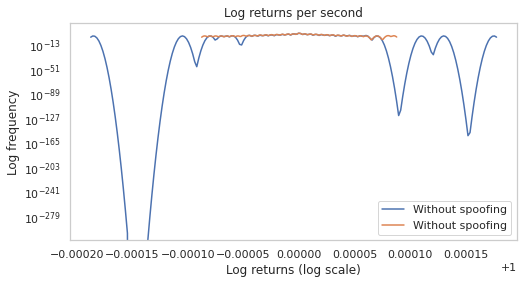

In [127]:
# calculate returns
returns = np.array((smidprice[1:]))/np.array((smidprice[:-1]))
vanilla_returns = np.array((vanilla_smidprice[1:]))/np.array((vanilla_smidprice[:-1]))

# log values
log_returns = np.log(returns)
vanilla_log_returns = np.log(vanilla_returns)

# plot
plt.figure(figsize=(8,4))
sns.distplot(returns, hist =False, kde = True, label = 'Without spoofing', norm_hist = True)
sns.distplot(vanilla_returns, hist =False, kde = True, label = 'Without spoofing', norm_hist = True)
plt.yscale("log")
plt.legend()
plt.ylabel('Log frequency')
plt.xlabel('Log returns (log scale)')
plt.title('Log returns per second')
plt.grid(False)

plt.show();

# plt.savefig('Log_returns.png')

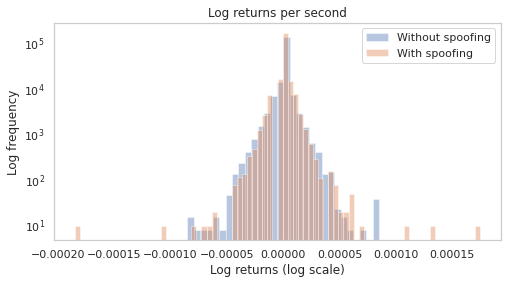

In [128]:
# calculate returns
returns = np.array((smidprice[1:]))/np.array((smidprice[:-1]))
vanilla_returns = np.array((vanilla_smidprice[1:]))/np.array((vanilla_smidprice[:-1]))

# log values
log_returns = np.log(returns)
vanilla_log_returns = np.log(vanilla_returns)

# plot
plt.figure(figsize=(8,4))
plt.hist(vanilla_log_returns, bins=30, density=1, alpha=0.4, label = 'Without spoofing')
plt.hist(log_returns, bins=80, density=1, alpha=0.4, label = 'With spoofing')
plt.yscale("log")
plt.legend()
plt.ylabel('Log frequency')
plt.xlabel('Log returns (log scale)')
plt.title('Log returns per second')
plt.grid(False)

plt.show();

# plt.savefig('Log_returns.png')

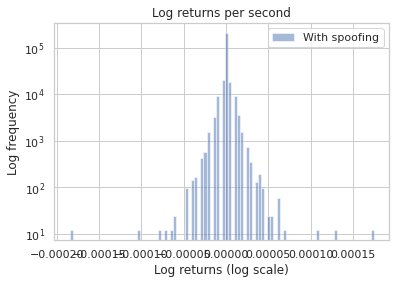

In [72]:
plt.hist(log_returns, bins=100, density=1, alpha=0.5, label = 'With spoofing')
plt.yscale("log")
plt.legend()
plt.ylabel('Log frequency')
plt.xlabel('Log returns (log scale)')
plt.title('Log returns per second')
plt.show();

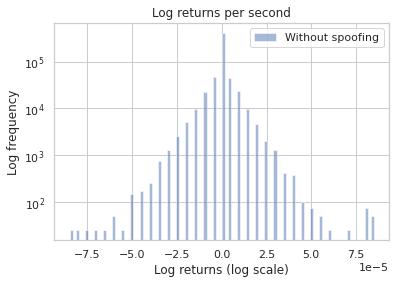

In [73]:
plt.hist(vanilla_log_returns, bins=100, density=1, alpha=0.5, label = 'Without spoofing')
plt.yscale("log")
plt.legend()
plt.ylabel('Log frequency')
plt.xlabel('Log returns (log scale)')
plt.title('Log returns per second')
plt.show();



### 2. Absence of autocorrelations in periods greater than 20 minutes

We will set the asset return times scale $(\Delta t)$ to 1 minute and period $\tau$ to 30 minutes.


\begin{equation}
corr(r_{t + \tau, \Delta t}, r_{t, \Delta t})
\end{equation}

The graph shows a 30 minute batches

-- *Need more samples* --


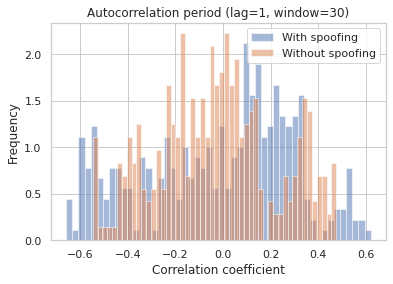

In [103]:
# set correlation period and asset return interval

# check correlation period of upto an hour
corr_period = range(1, 61)
asset_return_interval = 1


# Convert price data to asset returns data
returns = fmidprice.diff(periods=asset_return_interval)[asset_return_interval:]#.copy().rename(columns={'midprice':'return'})
vanilla_returns = vanilla_fmidprice.astype(float).diff(periods=asset_return_interval)[asset_return_interval:]#.copy().rename(columns={'midprice':'return'})


# convert to log returns
corr = []
vanilla_corr = []

# initialise
i = 0
j = 0
batch_len = 20

# Convert asset returns data to correlation over set periods 
while i + batch_len*2 <= len(returns):
    
    corr.append(np.corrcoef(returns.iloc[i:i+batch_len,0].astype(float), returns.iloc[i+batch_len:i+batch_len*2,0].astype(float))[0, 1])
    i += 1

while j + batch_len*2 <= len(vanilla_returns):
    
    vanilla_corr.append(np.corrcoef(vanilla_returns.iloc[j:j+batch_len,0].astype(float), vanilla_returns.iloc[j+batch_len:j+batch_len*2,0].astype(float))[0, 1])
    j += 1

# plot
plt.hist(corr, bins=50, density=1, label="With spoofing", alpha=0.5)
plt.hist(vanilla_corr, bins=50, density=1, label="Without spoofing", alpha=0.5)

plt.title('Autocorrelation period (lag=1, window=30)')
plt.ylabel('Frequency')
plt.xlabel('Correlation coefficient')

plt.legend()
plt.show();


# plt.savefig('Autocorrelation_period')

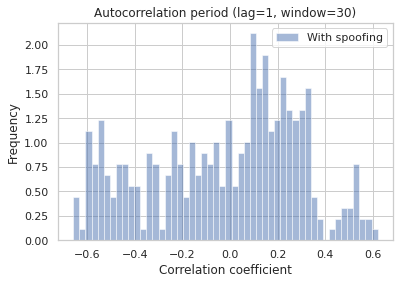

In [104]:
plt.hist(corr, bins=50, density=1, label="With spoofing", alpha=0.5)

plt.title('Autocorrelation period (lag=1, window=30)')
plt.ylabel('Frequency')
plt.xlabel('Correlation coefficient')

plt.legend()
plt.show();

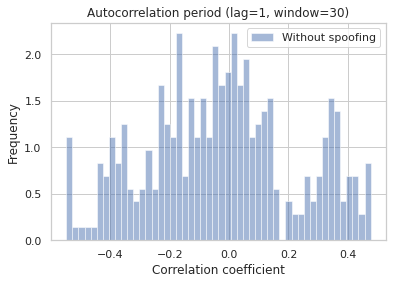

In [105]:
plt.hist(vanilla_corr, bins=50, density=1, label="Without spoofing", alpha=0.5)

plt.title('Autocorrelation period (lag=1, window=30)')
plt.ylabel('Frequency')
plt.xlabel('Correlation coefficient')

plt.legend()
plt.show();

/home/aldo/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/aldo/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


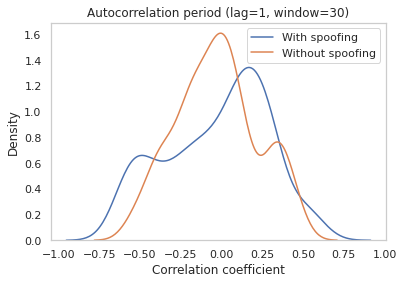

In [114]:
sns.distplot(corr, hist =False, kde = True, label = 'With spoofing', norm_hist = True)
sns.distplot(vanilla_corr, hist =False, kde = True, label = 'Without spoofing', norm_hist = True)
plt.title('Autocorrelation period (lag=1, window=30)')
plt.ylabel('Density')
plt.xlabel('Correlation coefficient')
plt.grid(False)

plt.legend()
plt.show();

### 3. Volatility clustering 
We will set the asset return times scale $(\Delta t)$ to 1 minute and $\tau$ to between 1 minute and 60 min
 


\begin{equation}
corr(r_{t + \tau, \Delta t}^2, r_{t, \Delta t}^2)
\end{equation}

*--We need more data--*

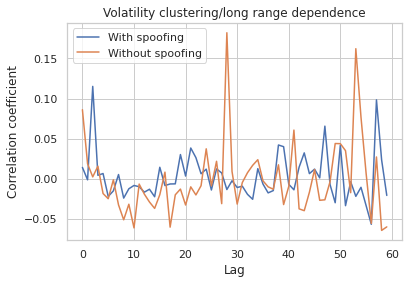

In [78]:
# set correlation period and asset return interval

# check correlation period of upto an hour
corr_period = range(1, 61)
asset_return_interval = 1


corr = []
sim_corr = []


# Convert price data to asset returns data
returns = fmidprice.diff(periods=1)[1:]
vanilla_returns = vanilla_fmidprice.diff(periods=1)[1:]


# Convert asset returns data to correlation over set periods 
for i in corr_period:
    
    corr.append(np.corrcoef(returns.iloc[0:-1*i,0].astype(float)**2, returns.iloc[i:,0].astype(float)**2)[0, 1])
    sim_corr.append(np.corrcoef(vanilla_returns.iloc[0:-1*i,0].astype(float)**2, vanilla_returns.iloc[i:,0].astype(float)**2)[0, 1])


# Plot correlation
plt.plot(corr, label="With spoofing")
plt.plot(sim_corr, label="Without spoofing")
plt.title('Volatility clustering/long range dependence')
plt.ylabel('Correlation coefficient')
plt.xlabel('Lag')

plt.legend()

# plt.savefig('Volatility_clustering.png')

In [79]:
len(fmidprice.diff(periods=1)[1:])

389

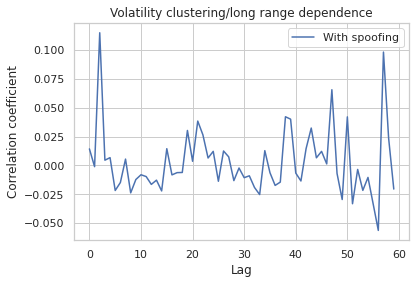

In [80]:
plt.plot(corr, label="With spoofing")
plt.title('Volatility clustering/long range dependence')
plt.ylabel('Correlation coefficient')
plt.xlabel('Lag')

plt.legend()

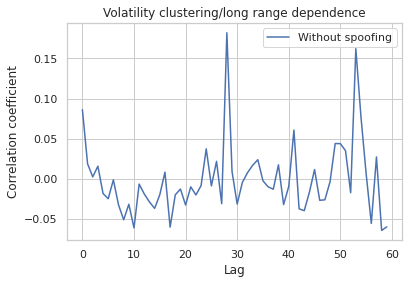

In [81]:
plt.plot(sim_corr, label="Without spoofing")
plt.title('Volatility clustering/long range dependence')
plt.ylabel('Correlation coefficient')
plt.xlabel('Lag')

plt.legend()

### 4. Volume/volatility correlation

not so good. We need a way to find actual volume as opposed to LOB volume

In [115]:
# 30 minutes of volume and volatility collected per observation
corr_len = 30

# 100 samples of 30 minute volume/volatility to calculate correlation
size = 50 #50

# append the 100 samples of correlation in "corr" variable
corr = []
vanilla_corr = []

In [116]:
"""
for simulated data
"""

# select number of samples with a predetermined size
for batch_end in range(size, len(ohlcv)):

    # initialise for each batch
    volume = []
    volatility = []
    
    # find correlation for each batch by calculating volume and volatility
    for i in range(batch_end - size, batch_end - corr_len):
        
        volume.append(ohlcv.volume[i:i+corr_len].sum())
        volatility.append(ohlcv.open[i:i+corr_len].std())

    corr.append(np.corrcoef(volume, volatility)[0,1])
    
for batch_end in range(size, len(vanilla_ohlcv)):


    # initialise for each batch
    volume = []
    volatility = []

    # find correlation for each batch by calculating volume and volatility
    for i in range(batch_end - size, batch_end - corr_len):

        volume.append(vanilla_ohlcv.volume[i:i+corr_len].sum())
        volatility.append(vanilla_ohlcv.open[i:i+corr_len].std())
        
    vanilla_corr.append(np.corrcoef(volume, volatility)[0,1])

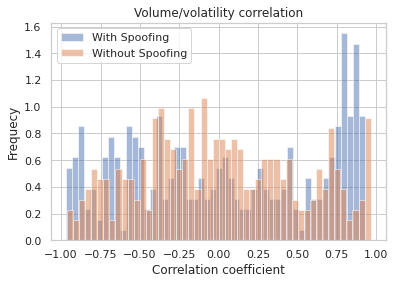

In [117]:
# plot
plt.hist(corr, bins=50, density=1, alpha=0.5, label='With Spoofing')
plt.hist(vanilla_corr, bins=50, density=1, alpha=0.5, label='Without Spoofing')

plt.title('Volume/volatility correlation')
plt.ylabel('Frequecy')
plt.xlabel('Correlation coefficient')
plt.legend()
plt.show()

# plt.savefig('Volume_volatility_correlation.png')

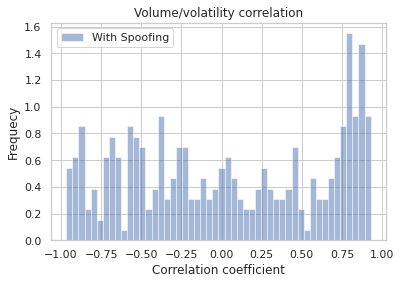

In [118]:
# plot
plt.hist(corr, bins=50, density=1, alpha=0.5, label='With Spoofing')

plt.title('Volume/volatility correlation')
plt.ylabel('Frequecy')
plt.xlabel('Correlation coefficient')
plt.legend()
plt.show()

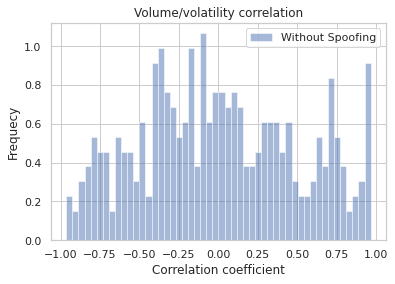

In [119]:
# plot
plt.hist(vanilla_corr, bins=50, density=1, alpha=0.5, label='Without Spoofing')

plt.title('Volume/volatility correlation')
plt.ylabel('Frequecy')
plt.xlabel('Correlation coefficient')
plt.legend()
plt.show()

/home/aldo/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/aldo/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


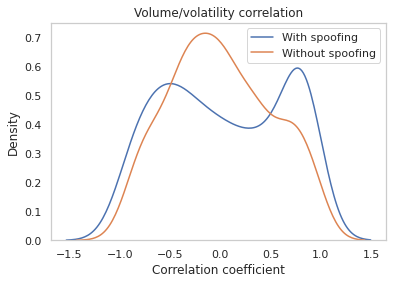

In [120]:
sns.distplot(corr, hist =False, kde = True, label = 'With spoofing')
sns.distplot(vanilla_corr, hist =False, kde = True, label = 'Without spoofing')
plt.title('Volume/volatility correlation')
plt.ylabel('Density')
plt.xlabel('Correlation coefficient')
plt.grid(False)

plt.legend()
plt.show();

### 5. Number of orders in a fixed time window

Number of orders in a fixed time window is approximated by gamma/lognormal distribution 

In [88]:
# initialise
interval = 5 #5 minute interval
order_count = []
sim_order_count = []

In [89]:
# identifty rough starting time - probably to the nearest minute
sim_start_time = order_stream.Time[0].ceil("min")
sim_end_time = order_stream.Time[-1].floor("min")
sim_time_delta = sim_end_time - sim_start_time
sim_total_minutes = int(sim_time_delta.total_seconds()/60)

# find out number of orders in 5 minute interval
# loop this by shifting interval by 1 minute at a time
for i in range(sim_total_minutes - interval):
    
    sim_int_start = sim_start_time + pd.Timedelta(minutes=i)
    sim_int_end = sim_start_time + pd.Timedelta(minutes=5+i)

    sim_order_count.append(len(order_stream.index[(order_stream.index > sim_int_start) & (order_stream.index < sim_int_end)]))

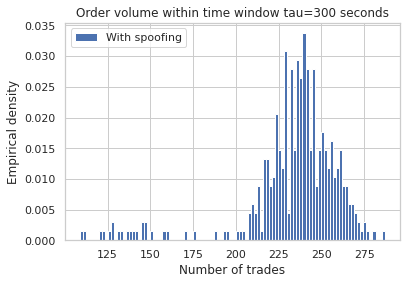

In [90]:
# plot histogram of results
plt.hist(sim_order_count, 100, density=1, label='With spoofing')

# plot weibull distribution
#plt.plot(order_count, stats.gamma.pdf(order_count, *stats.gamma.fit(order_count, 100)))
plt.title('Order volume within time window tau=300 seconds')
plt.ylabel('Empirical density')
plt.xlabel('Number of trades')
plt.legend()
plt.show()

# plt.savefig('Order_Volume.png')
#plt.plot(order_count, stats.exponweib.pdf(sim_order_count, *stats.exponweib.fit(sim_order_count, 1, 1, scale=2, loc=0)))

In [91]:
# initialise
interval = 5 #5 minute interval
order_count = []
sim_order_count = []

In [92]:
# identifty rough starting time - probably to the nearest minute
sim_start_time = vanilla_order_stream.Time[0].ceil("min")
sim_end_time = vanilla_order_stream.Time[-1].floor("min")
sim_time_delta = sim_end_time - sim_start_time
sim_total_minutes = int(sim_time_delta.total_seconds()/60)

# find out number of orders in 5 minute interval
# loop this by shifting interval by 1 minute at a time
for i in range(sim_total_minutes - interval):
    
    sim_int_start = sim_start_time + pd.Timedelta(minutes=i)
    sim_int_end = sim_start_time + pd.Timedelta(minutes=5+i)

    sim_order_count.append(len(vanilla_order_stream.index[(vanilla_order_stream.index > sim_int_start) & (vanilla_order_stream.index < sim_int_end)]))

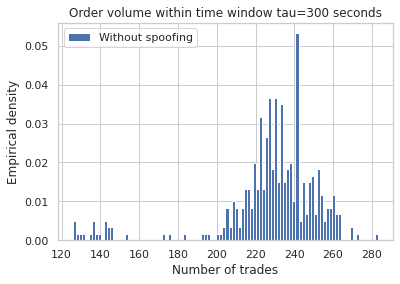

In [93]:
# plot histogram of results
plt.hist(sim_order_count, 100, density=1, label='Without spoofing')

# plot weibull distribution
#plt.plot(order_count, stats.gamma.pdf(order_count, *stats.gamma.fit(order_count, 100)))
plt.title('Order volume within time window tau=300 seconds')
plt.ylabel('Empirical density')
plt.xlabel('Number of trades')
plt.legend()
plt.show()

### 6. Order interarrival times

Order inter-arrival times are suggested to be fit into exponential, lognormal, and Weibull distributions

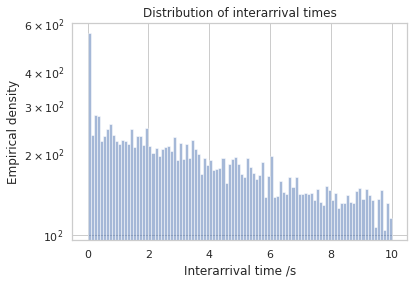

In [94]:
#inter_arrival = order_stream.time.diff(1)[1:].dt.total_seconds()
sim_inter_arrival = order_stream.Time.diff(1)[1:].dt.microseconds*10e-6


#plt.hist(inter_arrival, bins=100, log=True, label="Actual", alpha=0.5)
plt.hist(sim_inter_arrival, bins=100, log=True, alpha=0.5)
plt.title('Distribution of interarrival times')
plt.ylabel('Empirical density')
plt.xlabel('Interarrival time /s')
plt.show()

# plt.savefig('Distribution_interarrival_times.png')

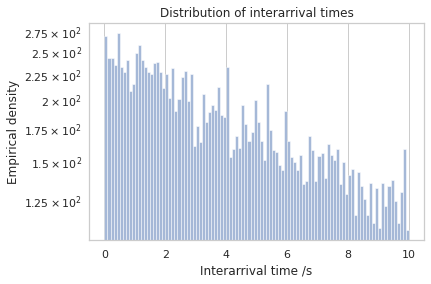

In [95]:
#inter_arrival = order_stream.time.diff(1)[1:].dt.total_seconds()
sim_inter_arrival = vanilla_order_stream.Time.diff(1)[1:].dt.microseconds*10e-6


#plt.hist(inter_arrival, bins=100, log=True, label="Actual", alpha=0.5)
plt.hist(sim_inter_arrival, bins=100, log=True, alpha=0.5)
plt.title('Distribution of interarrival times')
plt.ylabel('Empirical density')
plt.xlabel('Interarrival time /s')
plt.show()

<AxesSubplot:ylabel='quantity'>

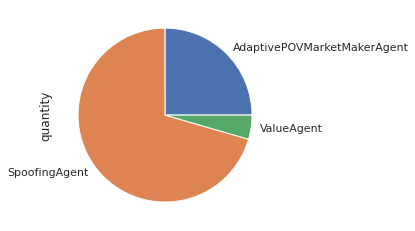

In [69]:
logs_df[logs_df.EventType=='ORDER_CANCELLED'].groupby('agent_type').sum()['quantity'].plot.pie()

<AxesSubplot:ylabel='quantity'>

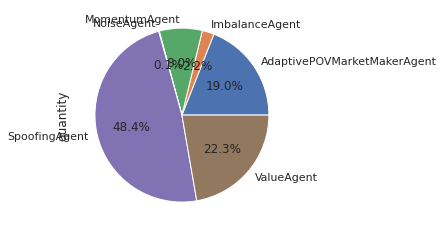

In [70]:
logs_df[logs_df.EventType=='ORDER_SUBMITTED'].groupby('agent_type').sum()['quantity'].plot.pie(autopct='%1.1f%%')